In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from statsmodels.sandbox.stats.runs import runstest_1samp
from sklearn.preprocessing import StandardScaler

In [2]:
df_nasd = pd.read_csv('Dataset updated/NASDAQ.csv')
df_infy_nyse = pd.read_csv('Dataset updated/INFOSYS.ADR-2010-2022.csv')
df_infy_nse = pd.read_csv('Dataset updated/INFOSYS.NSE-2010-2022.csv')
df_infy_nse = df_infy_nse.dropna().reset_index(drop=True)

In [3]:
class ShapingDF:
    def __init__(self, nse, nyse, idx):
        self.nse = nse
        self.nyse = nyse.add_prefix('nyse_')
        self.idx = idx.add_prefix('idx_')
        self.df_temp = pd.merge(self.nse, self.nyse, left_on='Date', right_on='nyse_Date')
        self.df_temp = pd.merge(self.df_temp, self.idx, left_on='Date', right_on='idx_Date')
    
    def DF_concat(self):
        nse_Open = pd.Series(self.df_temp['Open'].iloc[1:].reset_index(drop=True), name="nse_Open") #
        nse_preClose = pd.Series(self.df_temp['Close'].iloc[:-1], name="nse_preClose") #
        
        df_temp_drop0 = self.df_temp.drop(index = 0).reset_index(drop=True)
        nse_Close_Open = df_temp_drop0['Close'] / df_temp_drop0['Open'] 
        for i in nse_Close_Open.index:
            if nse_Close_Open[i] > 1:
                nse_Close_Open[i] = 1
            else:
                nse_Close_Open[i] = 0
        nse_Close_Open = pd.Series(pd.Categorical(nse_Close_Open), name="nse_Close_Open") # 
        
        df_temp_dropLast = self.df_temp[:-1]
        df_preNYSE_IDX = df_temp_dropLast.drop(columns=['Open', 'Close', 'High', 'Low', 'Adj Close', 'Volume', 
                                                        'nyse_Date', 'nyse_Adj Close', 'nyse_Volume', 
                                                        'idx_Date', 'idx_Adj Close', 'idx_Volume'])
       
        
        return pd.concat([nse_Close_Open, nse_preClose, nse_Open, df_preNYSE_IDX], axis=1)
    
    

In [4]:
test = ShapingDF(df_infy_nse, df_infy_nyse, df_nasd)

# EDA

In [5]:
DF = test.DF_concat().drop(columns='Date')
DF

,nse_Close_Open,nse_preClose,nse_Open,nyse_Open,nyse_High,nyse_Low,nyse_Close,idx_Open,idx_High,idx_Low,idx_Close
0,1.0,326.575012,327.500000,7.002500,7.112500,7.001250,7.095000,2294.409912,2311.149902,2294.409912,2308.419922
1,0.0,327.668762,335.375000,7.087500,7.125000,7.048750,7.122500,2307.270020,2313.729980,2295.620117,2308.709961
2,0.0,322.887512,323.325012,7.072500,7.072500,6.970000,7.013750,2307.709961,2314.070068,2295.679932,2301.090088
3,0.0,315.631256,314.875000,6.885000,6.896250,6.777500,6.800000,2298.090088,2301.300049,2285.219971,2300.050049
4,1.0,308.024994,309.387512,6.721250,6.856250,6.693750,6.817500,2292.239990,2317.600098,2290.610107,2317.169922
...,...,...,...,...,...,...,...,...,...,...,...
3079,1.0,1501.949951,1546.650024,19.090000,19.290001,18.920000,19.200001,10869.169922,11119.120117,10779.950195,11114.150391
3080,1.0,1570.099976,1575.150024,19.510000,19.790001,19.360001,19.750000,11124.750000,11352.429688,11069.830078,11323.330078
3081,1.0,1585.300049,1577.849976,19.620001,19.799999,19.549999,19.549999,11233.900391,11350.120117,11167.169922,11196.219727
3082,1.0,1594.000000,1597.150024,19.980000,20.059999,19.740000,19.760000,11474.820313,11492.620117,11241.150391,11358.410156


* **nse_Close_Open**: Close price - Open price in NSE. If Close price - Open price > 0, nse_Close_Open takes "1.0." Otherwise nse_Close_Open is "0.0."  
* **nse_preClose**: previous business day's Close price in NSE  
* **nse_Open**: Open_price in NSE  
* **nyse_Open**: previous business day's Open price in NYSE  
* **nyse_High**: previous business day's High price in NYSE  
* **nyse_Low**: previous business day's Low price in NYSE  
* **nyse_Close**: previous business day's Close price in NYSE  
* **idx_Open**: previous business day's Open price in NASDAQ  
* **idx_High**: previous business day's High price in NASDAQ  
* **idx_Low**: previous business day's Low price in NASDAQ  
* **idx_Close**: previous business day's Close price in NASDAQ  

## Box plots

As shown in below, there is no siginificant difference between Close - Open > 0 and Close - Open < 0.

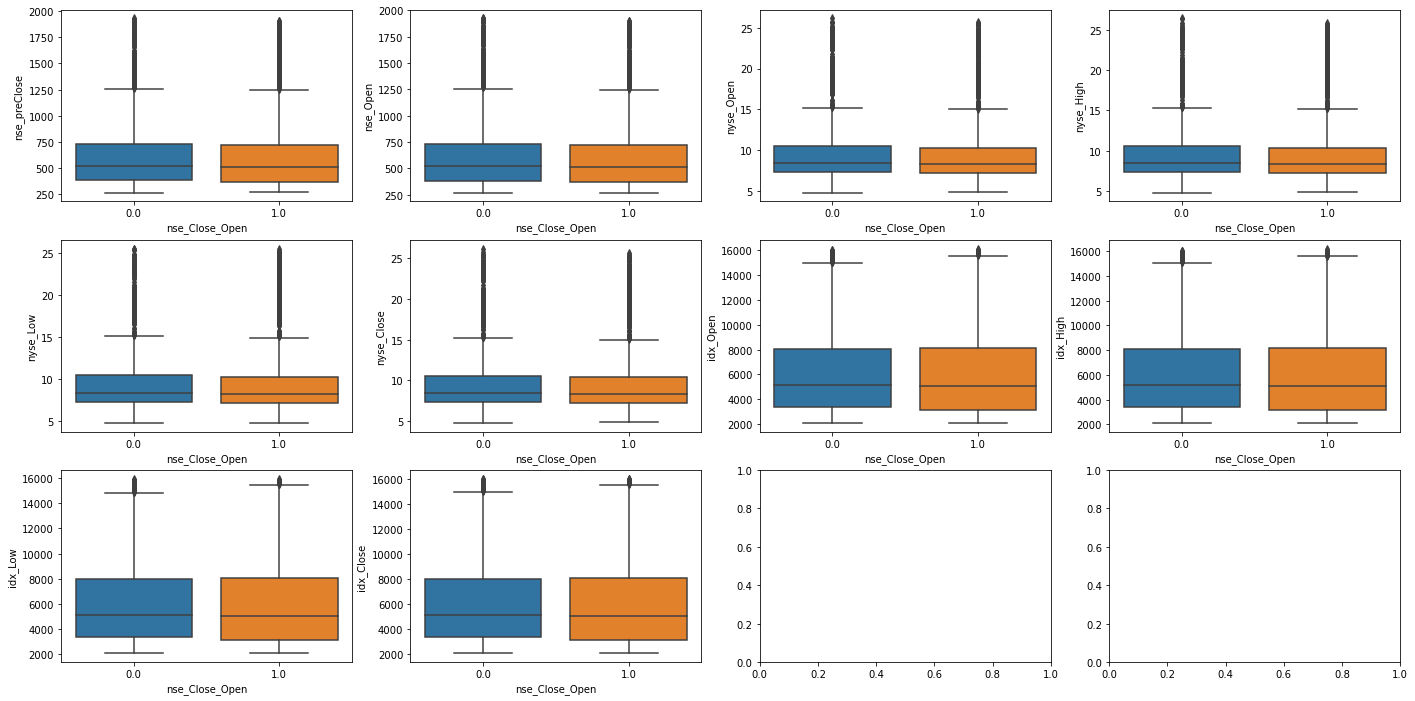

In [6]:
cols = DF.drop(columns='nse_Close_Open').columns 
fig, axes = plt.subplots(3, 4, figsize=(24, 12))
axes = axes.ravel()

for col, ax in zip(cols, axes):
    sns.boxplot(x='nse_Close_Open', y=col, data=DF, ax=ax)

plt.show()

## Scatter plot

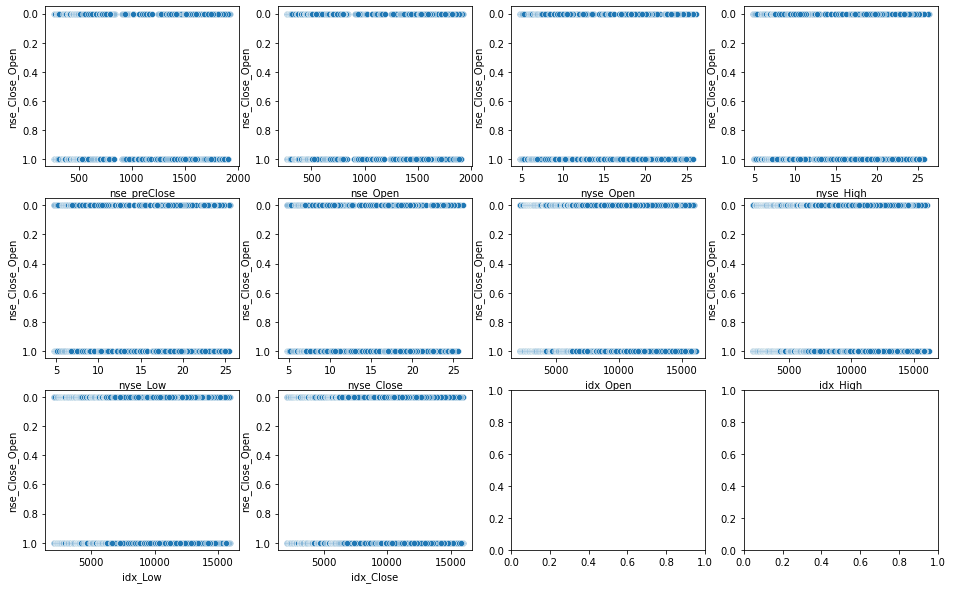

In [7]:
cols = DF.drop(columns='nse_Close_Open').columns 
fig, axes = plt.subplots(3, 4, figsize=(16, 10))
axes = axes.ravel()

for col, ax in zip(cols, axes):
    sns.scatterplot(x=col, y='nse_Close_Open', data=DF, ax=ax)

plt.show()

## Histogram

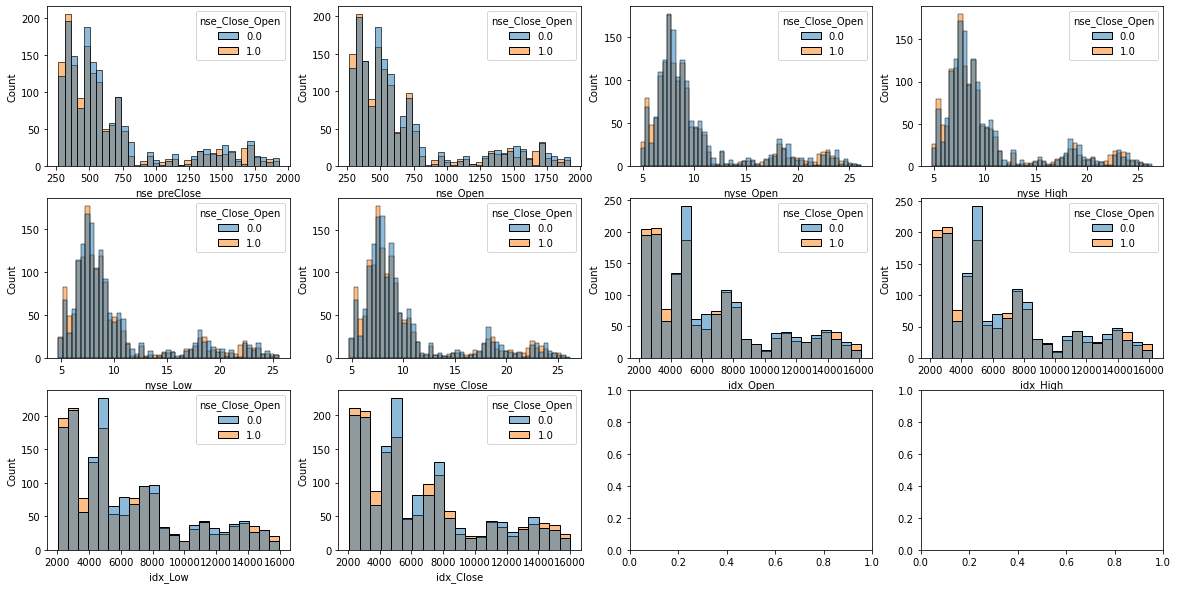

In [8]:
cols = DF.drop(columns='nse_Close_Open').columns 
fig, axes = plt.subplots(3, 4, figsize=(20, 10))
axes = axes.ravel()

for col, ax in zip(cols, axes):
    sns.histplot(x=col, hue='nse_Close_Open', data=DF, ax=ax)

plt.show()

## Pair plot

The distribution of Close - Open > 0 and the distribution of Close - Open < 0 are almost same. There seems to be two (three) bumps in their distribution, which means price has shiftted over last 10 years.

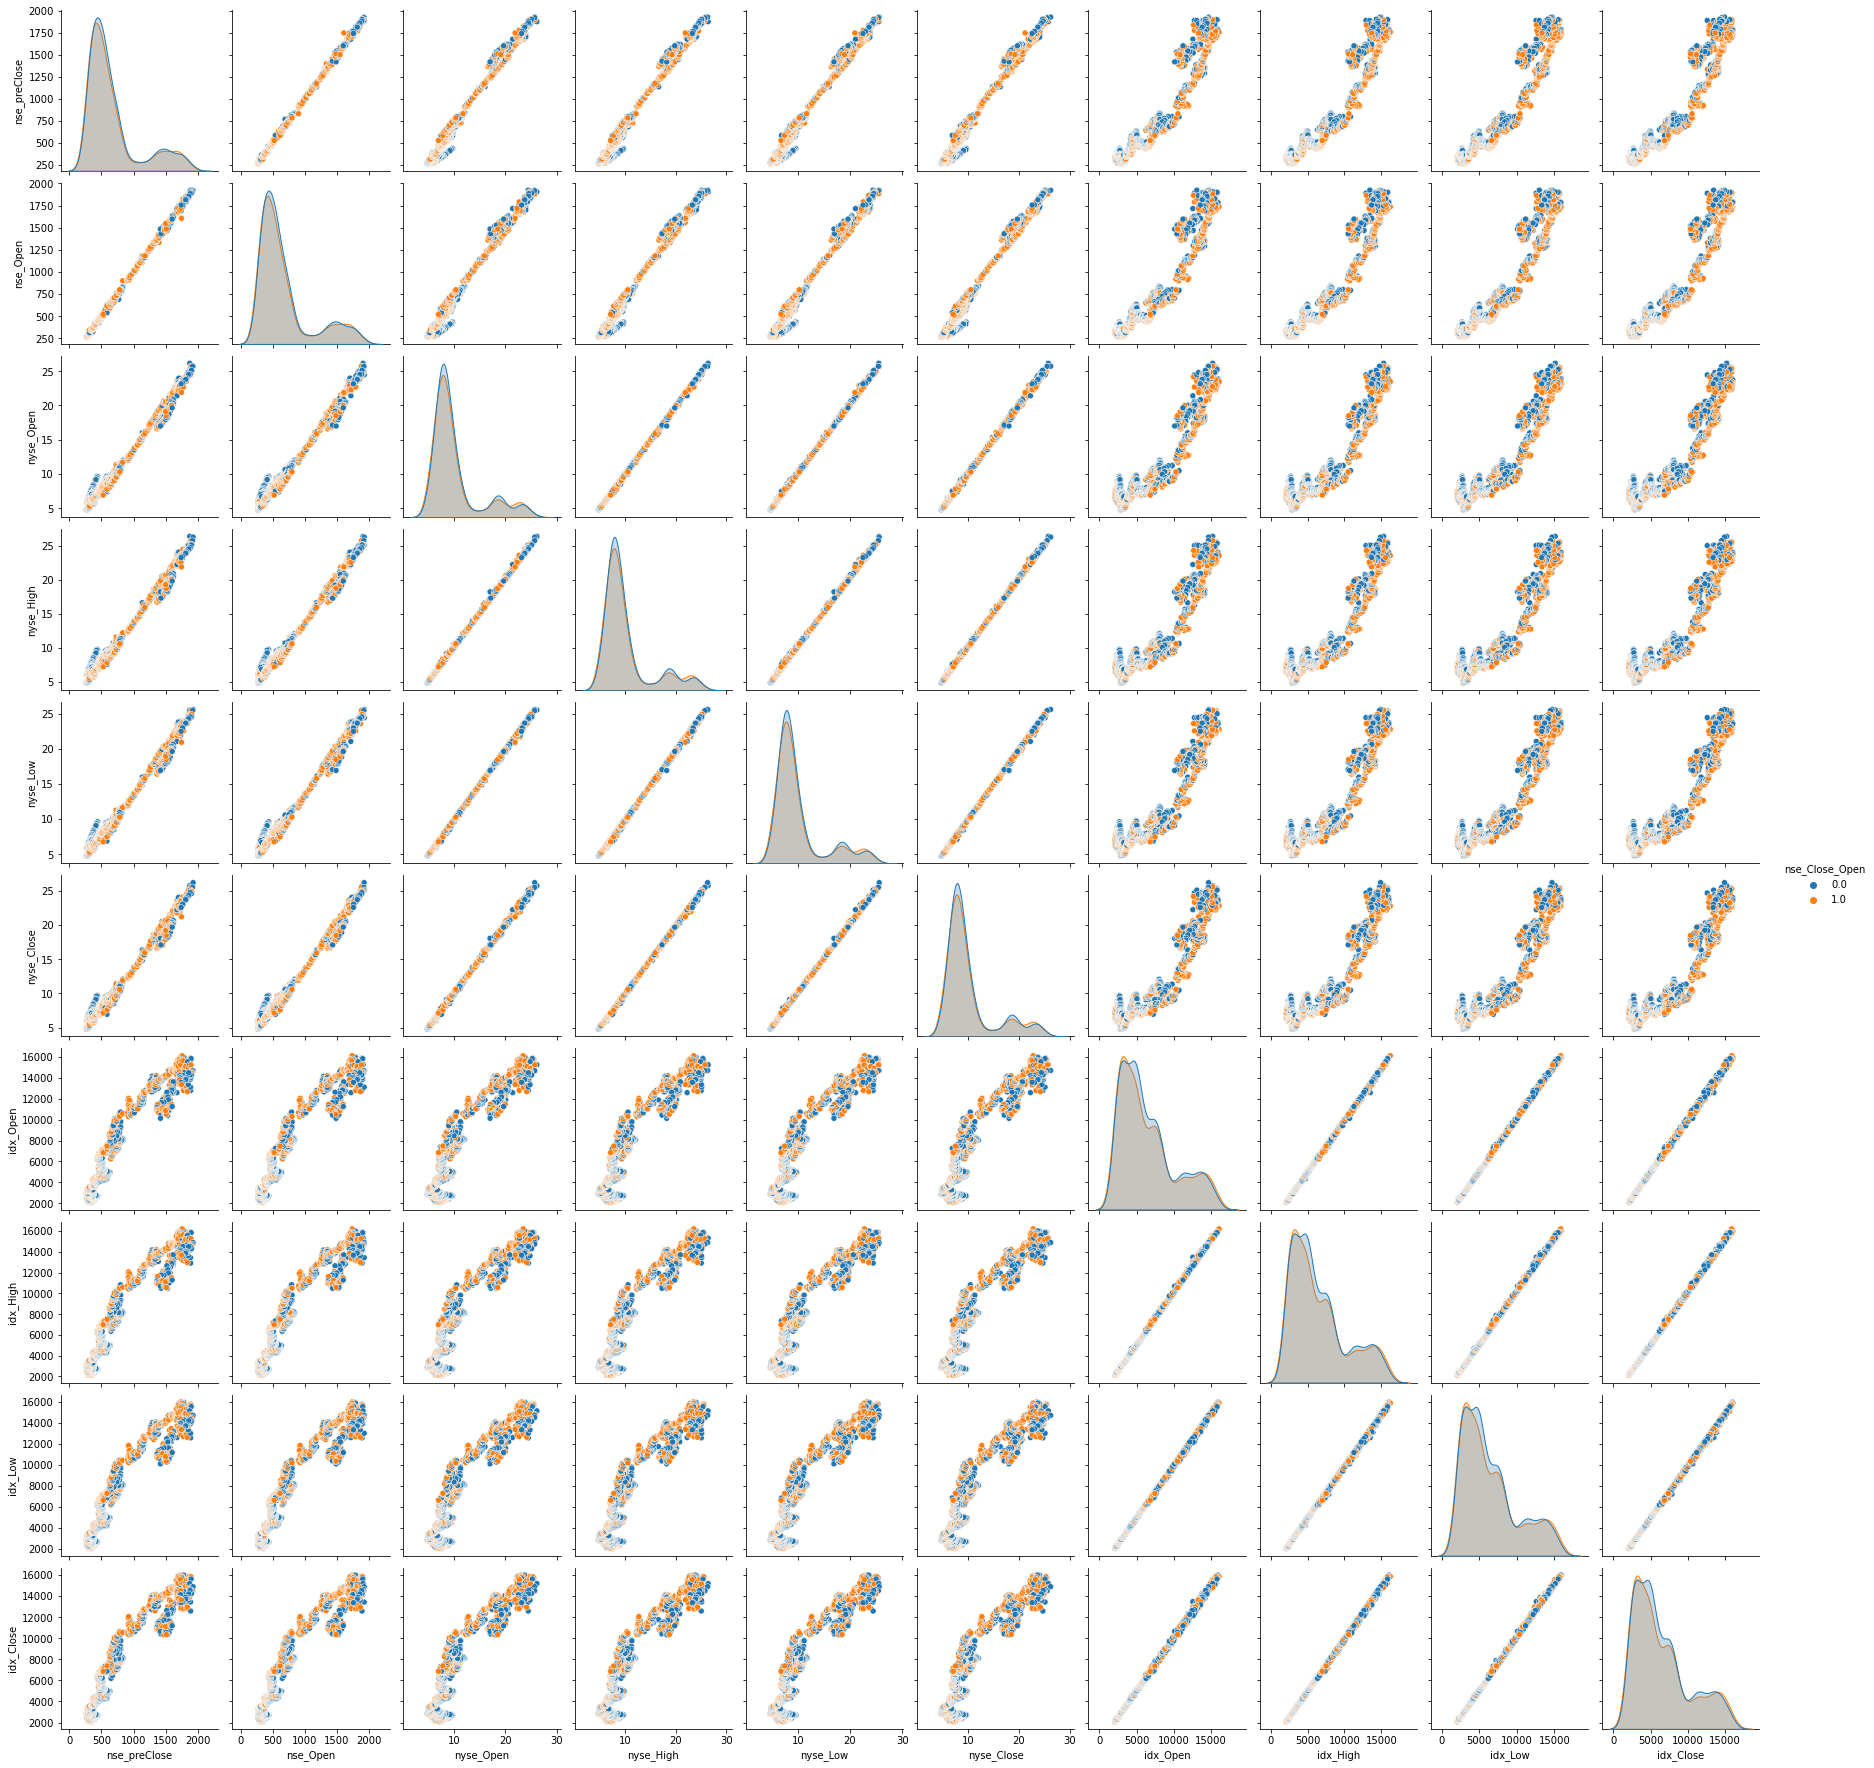

In [9]:
sns.pairplot(DF, hue = "nse_Close_Open")

## Add columns
nyse_Close - nyse_Open and idx_Close - idx_Close seem to be related to nse_Close_Open, so I will add these columns.

In [10]:
DF["nyse_Close_Open"] = DF["nyse_Close"] - DF["nyse_Open"]
DF["idx_Close_Open"] = DF["idx_Close"] - DF["idx_Open"]

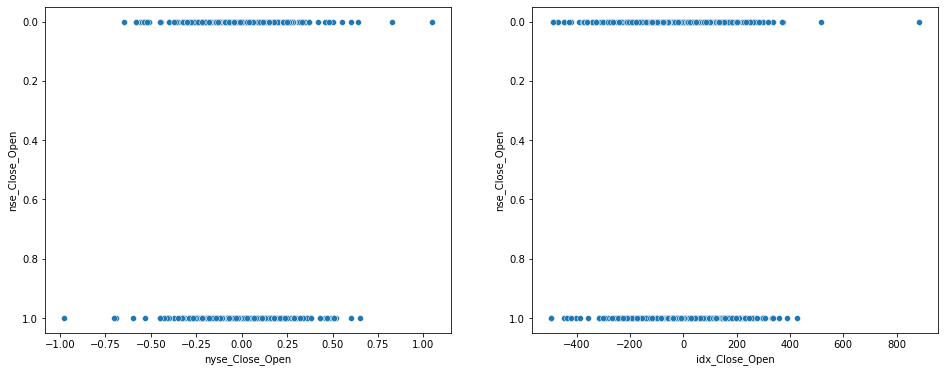

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
sns.scatterplot(x='nyse_Close_Open', y='nse_Close_Open', data=DF, ax=ax1)
sns.scatterplot(x='idx_Close_Open', y='nse_Close_Open', data=DF, ax=ax2)

plt.show()

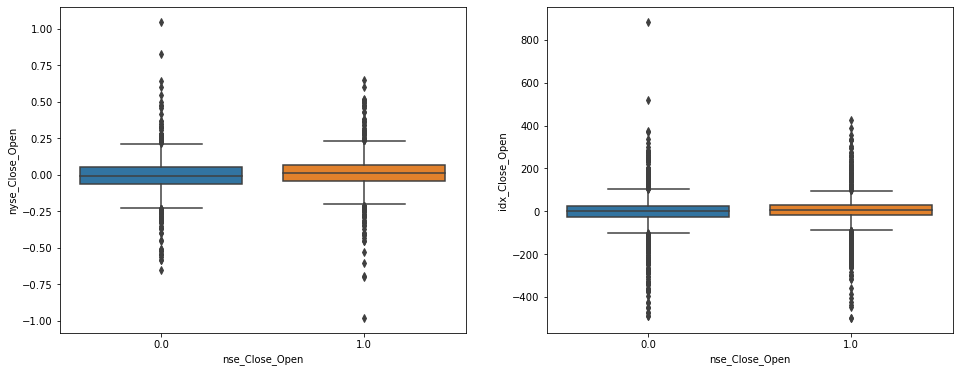

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
sns.boxplot(y='nyse_Close_Open', x='nse_Close_Open', data=DF, ax=ax1)
sns.boxplot(y='idx_Close_Open', x='nse_Close_Open', data=DF, ax=ax2)

plt.show()

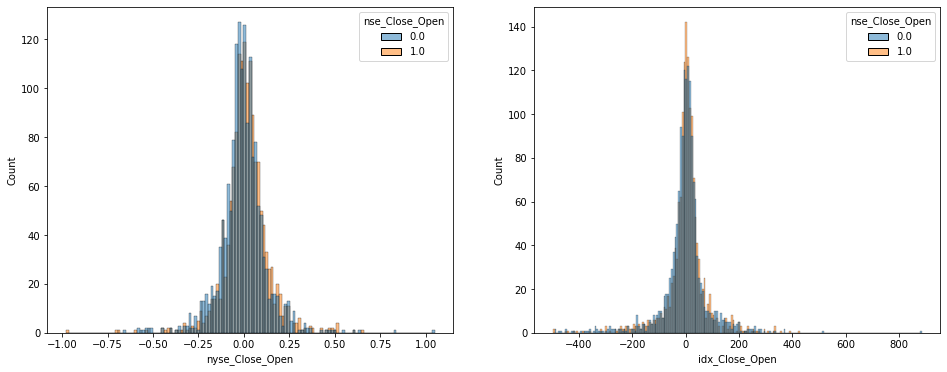

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
sns.histplot(x='nyse_Close_Open', hue='nse_Close_Open', data=DF, ax=ax1)
sns.histplot(x='idx_Close_Open', hue='nse_Close_Open', data=DF, ax=ax2)

plt.show()

# Each year

In [14]:
DF2 = test.DF_concat()
DF_10 = DF2[DF2["Date"].str.startswith('2010-')==True].drop(columns='Date')
DF_11 = DF2[DF2["Date"].str.startswith('2011-')==True].drop(columns='Date')
DF_12 = DF2[DF2["Date"].str.startswith('2012-')==True].drop(columns='Date')
DF_13 = DF2[DF2["Date"].str.startswith('2013-')==True].drop(columns='Date')
DF_14 = DF2[DF2["Date"].str.startswith('2014-')==True].drop(columns='Date')
DF_15 = DF2[DF2["Date"].str.startswith('2015-')==True].drop(columns='Date')
DF_16 = DF2[DF2["Date"].str.startswith('2016-')==True].drop(columns='Date')
DF_17 = DF2[DF2["Date"].str.startswith('2017-')==True].drop(columns='Date')
DF_18 = DF2[DF2["Date"].str.startswith('2018-')==True].drop(columns='Date')
DF_19 = DF2[DF2["Date"].str.startswith('2019-')==True].drop(columns='Date')
DF_20 = DF2[DF2["Date"].str.startswith('2020-')==True].drop(columns='Date')
DF_21 = DF2[DF2["Date"].str.startswith('2021-')==True].drop(columns='Date')
#DF_2022 = DF2[DF2["Date"].str.startswith('2022-')==True].drop(columns='Date')

## The histogram of nse_Open for each year

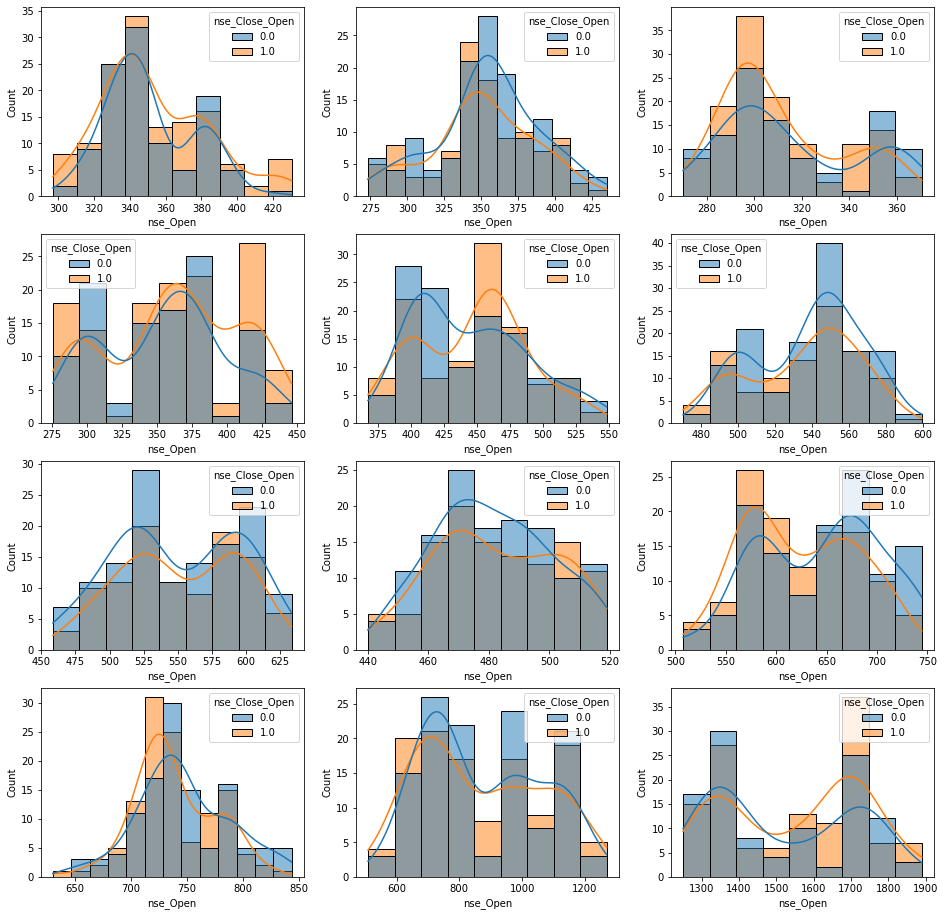

In [15]:
data = [DF_10,DF_11,DF_12,DF_13,DF_14,DF_15,DF_16,DF_17,DF_18,DF_19,DF_20,DF_21]
fig, axes = plt.subplots(4, 3, figsize=(16, 16))
axes = axes.ravel()

for df, ax in zip(data, axes):
    sns.histplot(x='nse_Open', hue='nse_Close_Open', data=df, kde=True, ax=ax)

plt.show()

## Time series of nse_Open change colored by nse_Close_Open

It does not appear that nse_Close_Open = 1 is more common in upswings and nse_Close_Open = 0 is more common in downswings.

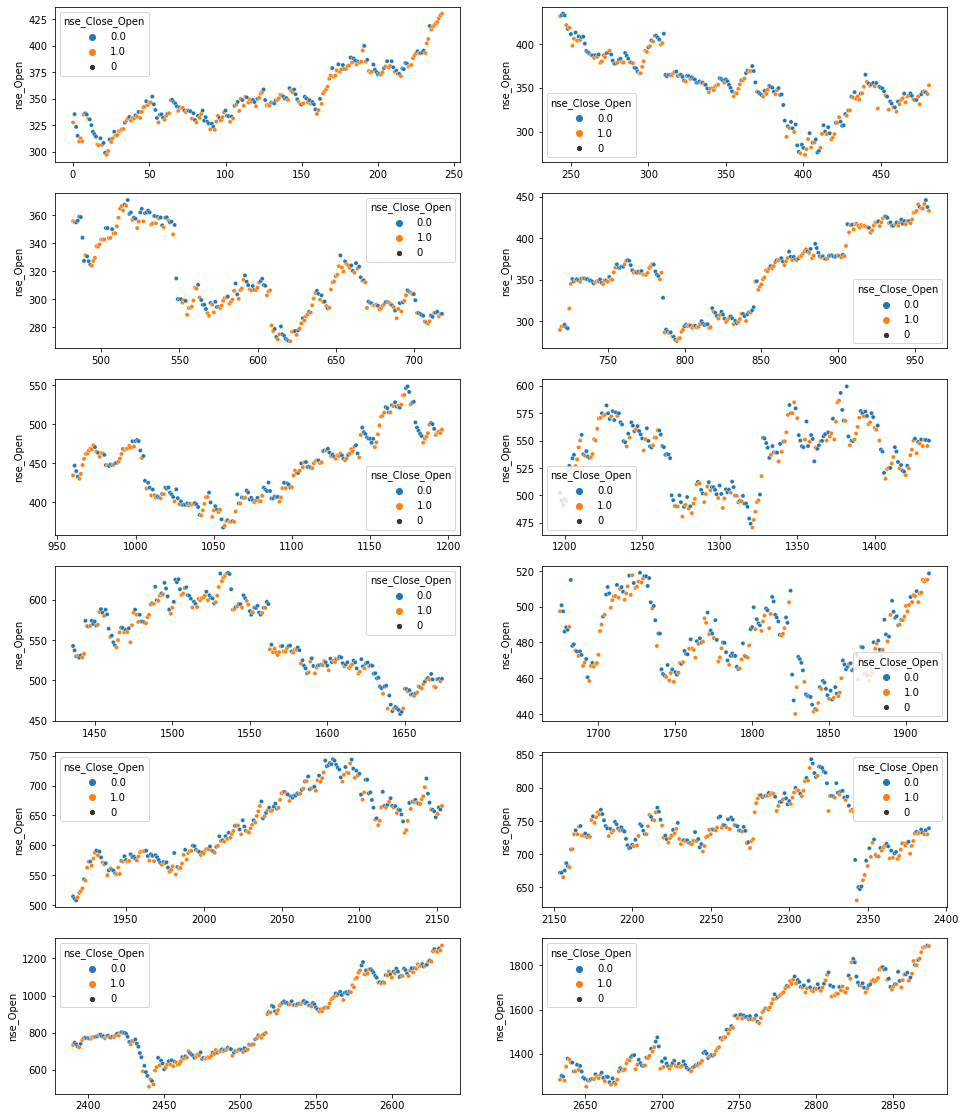

In [16]:
data = [DF_10,DF_11,DF_12,DF_13,DF_14,DF_15,DF_16,DF_17,DF_18,DF_19,DF_20,DF_21]
fig, axes = plt.subplots(6, 2, figsize=(16, 20))
axes = axes.ravel()

for df, ax in zip(data, axes):
    sns.scatterplot(x=df.index, y='nse_Open', hue="nse_Close_Open", data=df, ax=ax, size=0)

plt.show()

# Model - logistic regression

In [17]:
x = DF.iloc[:,1:]
y = DF.iloc[:,0]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=1)

scaler = StandardScaler().fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

model=LogisticRegression(penalty='none', max_iter=1000)
model_fit = model.fit(x_train, y_train)
model_fit_score = model.score(x_train, y_train)

In [18]:
# fitted y and cofusion matrix
y_fit = model.predict(x_train)
cm_train = confusion_matrix(y_train, y_fit)
print(cm_train)
print(classification_report(y_train, y_fit))

[[767 353]
 [646 392]]
              precision    recall  f1-score   support

         0.0       0.54      0.68      0.61      1120
         1.0       0.53      0.38      0.44      1038

    accuracy                           0.54      2158
   macro avg       0.53      0.53      0.52      2158
weighted avg       0.53      0.54      0.53      2158



In [19]:
# predicted y and confusion matrix
y_predict = model.predict(x_test)
cm_test = confusion_matrix(y_test, y_predict)
print(cm_test)
print(classification_report(y_test, y_predict))

[[310 143]
 [304 169]]
              precision    recall  f1-score   support

         0.0       0.50      0.68      0.58       453
         1.0       0.54      0.36      0.43       473

    accuracy                           0.52       926
   macro avg       0.52      0.52      0.51       926
weighted avg       0.52      0.52      0.50       926



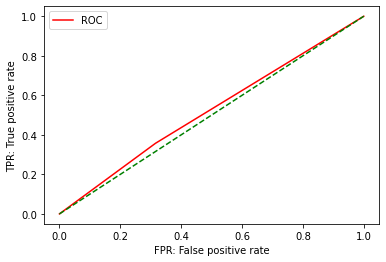

In [20]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, y_predict)

plt.plot(fpr, tpr, color='red', label='ROC')
plt.plot([0, 1], [0, 1], color='green', linestyle='--')
plt.xlabel('FPR: False positive rate')
plt.ylabel('TPR: True positive rate')
plt.legend()
plt.show()

# Random forest

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

x = DF.iloc[:,1:]
y = DF.iloc[:,0]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=1)


# model
model = RandomForestClassifier()

# learn from training data
model.fit(x_train, y_train)

# predict
test = model.predict(x_test)

# check accuracy
score = accuracy_score(y_test, test)
print(f"accuracy：{score * 100}%")

accuracy：53.56371490280778%


In [31]:
fti = model.feature_importances_ 
for i, feat in enumerate(x.columns):
    print('\t{0:20s} : {1:>.6f}'.format(feat, fti[i]))

	nse_preClose         : 0.086060
	nse_Open             : 0.084733
	nyse_Open            : 0.075023
	nyse_High            : 0.078683
	nyse_Low             : 0.077924
	nyse_Close           : 0.076250
	idx_Open             : 0.075592
	idx_High             : 0.074751
	idx_Low              : 0.078633
	idx_Close            : 0.078812
	nyse_Close_Open      : 0.100498
	idx_Close_Open       : 0.113041


In [22]:
from sklearn.model_selection import RandomizedSearchCV

n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
max_features = [None, 'sqrt']
max_depth = [int(x) for x in np.linspace(start = 2, stop = 5, num = 4)]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators, 
               'max_features': max_features, 
               'max_depth': max_depth,
               'bootstrap': bootstrap}
rf_random = RandomizedSearchCV(estimator=model, param_distributions = random_grid,
                               n_iter = 100, cv = 5, random_state = 0)
rf_random.fit(x_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=100,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [2, 3, 4, 5],
                                        'max_features': [None, 'sqrt'],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000]},
                   random_state=0)

In [23]:
rf_random.best_params_

{'n_estimators': 600, 'max_features': None, 'max_depth': 2, 'bootstrap': False}

In [24]:
rf2 = RandomForestClassifier(n_estimators=600, max_features=None, max_depth=2, bootstrap=False)
rf2.fit(x_train, y_train)
test = rf2.predict(x_test)
score = accuracy_score(y_test, test)
print(f"accuracy：{score * 100}%")

accuracy：52.59179265658748%


In [30]:
fti = rf2.feature_importances_ 
for i, feat in enumerate(x.columns):
    print('\t{0:20s} : {1:>.6f}'.format(feat, fti[i]))

	nse_preClose         : 0.000000
	nse_Open             : 0.000000
	nyse_Open            : 0.000000
	nyse_High            : 0.000000
	nyse_Low             : 0.000000
	nyse_Close           : 0.000000
	idx_Open             : 0.119008
	idx_High             : 0.000000
	idx_Low              : 0.131535
	idx_Close            : 0.197341
	nyse_Close_Open      : 0.552116
	idx_Close_Open       : 0.000000


# Boosting

In [34]:
from sklearn.ensemble import GradientBoostingClassifier

x = DF.iloc[:,1:]
y = DF.iloc[:,0]

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=1)
gbrt = GradientBoostingClassifier()
gbrt.fit(x_train, y_train)

print("training accuracy: {:.3f}".format(gbrt.score(x_train, y_train)))
print("testing accuracy: {:.3f}".format(gbrt.score(x_test, y_test)))

training accuracy: 0.739
testing accuracy: 0.546


In [35]:
fti = gbrt.feature_importances_ 
for i, feat in enumerate(x.columns):
    print('\t{0:20s} : {1:>.6f}'.format(feat, fti[i]))

	nse_preClose         : 0.091004
	nse_Open             : 0.087540
	nyse_Open            : 0.054363
	nyse_High            : 0.043316
	nyse_Low             : 0.066556
	nyse_Close           : 0.070406
	idx_Open             : 0.054497
	idx_High             : 0.039048
	idx_Low              : 0.056594
	idx_Close            : 0.099428
	nyse_Close_Open      : 0.165694
	idx_Close_Open       : 0.171553


In [26]:
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
max_features = [None, 'sqrt']
max_depth = [int(x) for x in np.linspace(start = 2, stop = 5, num = 4)]
learning_rate = [0.1, 0.01, 0.001, 0.0001]
random_grid = {'n_estimators': n_estimators, 
               'max_features': max_features, 
               'max_depth': max_depth,
               'learning_rate': learning_rate}
bsting = RandomizedSearchCV(estimator=gbrt, param_distributions = random_grid,
                               n_iter = 100, cv = 5, random_state = 0)
bsting.fit(x_train, y_train)

RandomizedSearchCV(cv=5, estimator=GradientBoostingClassifier(), n_iter=100,
                   param_distributions={'learning_rate': [0.1, 0.01, 0.001,
                                                          0.0001],
                                        'max_depth': [2, 3, 4, 5],
                                        'max_features': [None, 'sqrt'],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000]},
                   random_state=0)

In [27]:
bsting.best_params_

{'n_estimators': 200,
 'max_features': None,
 'max_depth': 2,
 'learning_rate': 0.1}

In [32]:
gbrt2 = GradientBoostingClassifier(max_depth=2, n_estimators=200, max_features=None, learning_rate=0.1)
gbrt2.fit(x_train, y_train)

print("training accuracy: {:.3f}".format(gbrt.score(x_train, y_train)))
print("testing accuracy: {:.3f}".format(gbrt.score(x_test, y_test)))

training accuracy: 0.702
testing accuracy: 0.551


In [33]:
fti = gbrt2.feature_importances_ 
for i, feat in enumerate(x.columns):
    print('\t{0:20s} : {1:>.6f}'.format(feat, fti[i]))

	nse_preClose         : 0.100723
	nse_Open             : 0.085786
	nyse_Open            : 0.063951
	nyse_High            : 0.029051
	nyse_Low             : 0.078443
	nyse_Close           : 0.099404
	idx_Open             : 0.041720
	idx_High             : 0.050953
	idx_Low              : 0.073666
	idx_Close            : 0.100892
	nyse_Close_Open      : 0.174692
	idx_Close_Open       : 0.100718
